In [20]:
import pandas as pd
import html5lib
import matplotlib.pyplot as plt
import numpy as np

In [21]:
dataframes=[]
for k in range(2001,2019):
    for i in range(1,13):
#         if k==2017 and i==12: # not find table
#             continue
#         if k==2019 and i==3:
#             continue
        df = pd.read_html('./data/'+str(k)+'Y_'+str(i)+'M.xls',encoding='utf-8',header=0)
        dataframes.append(df[0])

In [22]:
df_nans=[]
for df in dataframes:
    df_nan=df[df.isna().any(1)]
    df_nan=df_nan.dropna(axis='columns')
    # 2007/12 2013/12 change
    df_nan.rename(columns={'類型代號':"基金名稱","基金統編":"基金規模","基金規模":"本月定時定額扣款筆數","單位淨值":"本月定時定額扣款人數","本月定時定額扣款筆數":"本月定時定額扣款金額"})
    df_nans.append(df_nan)

In [23]:
df_corrects=[]
df_filter = []
# for df in dataframes:
#     df_correct = df[~df.isna().any(1)]
#     df_corrects.append(df_correct)
for df in dataframes:
    df.rename(columns={"基金規模(台幣)":"基金規模","單位淨值(台幣)":"單位淨值","本月定時定額扣款金額(台幣)":"本月定時定額扣款金額"}, inplace=True)
    df_correct = df[~df.isna().any(1)]
    df_filter = []
    for name in df_correct['基金名稱']:
        if ("中國" in name or "俄羅斯" in name or "巴西" in name or "印度" in name or "醫療" in name or "生技" in name) :
            if("中國信託" in name):
                continue
            filter1 = (df_correct['類型代號'] == "AA2")
            filter2 = (df_correct['類型代號'] == "2")
            filter3 = (df_correct['基金名稱'] == name)
            df_filter.append(df_correct[((filter1 | filter2) & filter3)])
    df_corrects.append(pd.concat(df_filter))
df_corrects[0]

,類型代號,基金統編,基金名稱,基金規模,單位淨值,本月定時定額扣款筆數,本月定時定額扣款人數,本月定時定額扣款金額
86,2,97990289,元大中國基金,436898521,6.54,8,8,63000


In [24]:
def plot_image(id):
    navs=[]
    money=[]
    num=[]
    people=[]
    scales=[]
    id = str(id)
    id = id.zfill(8)
    for i in range(0,2*12):
        try:
            navs.append(df_corrects[i][df_corrects[i]['基金統編']==id]['單位淨值'].values[0])
            money.append(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款金額'].values[0])
            num.append(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款筆數'].values[0])
            people.append(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款筆數'].values[0])
            scales.append(df_corrects[i][df_corrects[i]['基金統編']==id]['基金規模'].values[0])
        except:
            pass
    plt.plot(navs)
    plt.title('Unit net value')
    plt.ylabel('Value')
    plt.xlabel('Months')
    plt.show()
    plt.title('SIP value')
    plt.plot(money)
    plt.ylabel('Value')
    plt.xlabel('Months')
    plt.show()
    plt.title('SIP Number of records')
    plt.plot(num)
    plt.ylabel('Value')
    plt.xlabel('Months')
    plt.show()
    plt.title('SIP Number of people')
    plt.plot(people)
    plt.ylabel('Value')
    plt.xlabel('Months')
    plt.show()
    plt.title('SIP Scale')
    plt.plot(scales)
    plt.ylabel('Value')
    plt.xlabel('Months')
    plt.show()
    

In [25]:
def monthFilter(month, length, data):
    subData = np.array(data[(month - (month % 6)) : (month + (5-(month % 6)) + 1)])
    if((data[month] - np.mean(subData)) / np.std(subData) > 1 or (data[month] - np.mean(subData)) / np.std(subData) < -1):
        return True
    else:
        return False

In [33]:
def plot_image():
    id_list = []
    id_temp = []
    aliveList=[]
    peopleChinaList = []
    peopleIndiaList = []
    peopleBrazilList = []
    peopleRussiaList = []
    peopleMedicalList = []
    markMonthChinaList =[]
    markMonthChinaList = []
    markMonthIndiaList = []
    markMonthBrazilList = []
    markMonthRussiaList = []
    markMonthlMedicalList = []
    for df in df_corrects:
        for filter_id in df['基金統編']:
#             id = str(filter_id)
#             id = id.zfill(8)
            id_temp.append(filter_id)
    id_list = list(set(id_temp))
    for id in id_list:
            isAlive = True
            navs=[]
            money=[]
            num=[]
            people=[]
            scales=[]
            name = ''
            isSaveList = []
            for i in range((17-3)*12 + 4,17*12 + 4):
                try:
                    name = df_corrects[i][df_corrects[i]['基金統編']==id]['基金名稱'].values[0]
                    navs.append(df_corrects[i][df_corrects[i]['基金統編']==id]['單位淨值'].values[0])
                    money.append(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款金額'].values[0])
                    num.append(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款筆數'].values[0])
                    people.append(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款人數'].values[0])
                    scales.append(df_corrects[i][df_corrects[i]['基金統編']==id]['基金規模'].values[0])
                    if(df_corrects[i][df_corrects[i]['基金統編']==id]['本月定時定額扣款人數'].values[0]) == 0 :
                        isAlive = False
                    if(i == 17*12 + 3 and isAlive):
                        aliveList.append(df_corrects[i][df_corrects[i]['基金統編']==id]['基金名稱'].values[0])
                except:
                    isAlive = False
                    navs.append(0)
                    money.append(0)
                    num.append(0)
                    people.append(0)
                    scales.append(0)
                    break
            if(isAlive):
                for i in range(0, len(people)):
                    if("中國" in name):
                        try:
                            peopleChinaList[i] += people[i]
                        except:
                            peopleChinaList.append(people[i])
                    elif("印度" in name):
                        try:
                            peopleIndiaList[i] += people[i]
                        except:
                            peopleIndiaList.append(people[i])
                    elif("巴西" in name):
                        try:
                            peopleBrazilList[i] += people[i]
                        except:
                            peopleBrazilList.append(people[i])
                    elif("俄羅斯" in name):
                        try:
                            peopleRussiaList[i] += people[i]
                        except:
                            peopleRussiaList.append(people[i])
                    else:
                        try:
                            peopleMedicalList[i] += people[i] 
                        except:
                            peopleMedicalList.append(people[i])
                plt.plot(navs)
                plt.title(id + 10*' ' +'Unit net value')
                plt.ylabel('Value')
                plt.xlabel('Months')
                plt.show()
                plt.title(id + 10*' ' +'SIP value')
                plt.plot(money)
                plt.ylabel('Value')
                plt.xlabel('Months')
                plt.show()
                plt.title(id + 10*' ' +'SIP Number of records')
                plt.plot(num)
                plt.ylabel('Value')
                plt.xlabel('Months')
                plt.show()
                plt.title(id + 10*' ' +'SIP Number of people')
                plt.plot(people)
                plt.ylabel('Value')
                plt.xlabel('Months')
                plt.show()
                plt.title(id + 10*' ' +'SIP Scale')
                plt.plot(scales)
                plt.ylabel('Value')
                plt.xlabel('Months')
                plt.show()
    for i in range(0, len(peopleChinaList)):
        if(monthFilter(i, 6, peopleChinaList)):
            markMonthChinaList.append(i)
    for i in range(0, len(peopleBrazilList)):
        if(monthFilter(i, 6, peopleBrazilList)):
            markMonthBrazilList.append(i)
    for i in range(0, len(peopleIndiaList)):
        if(monthFilter(i, 6, peopleIndiaList)):
            markMonthIndiaList.append(i)
    for i in range(0, len(peopleRussiaList)):
        if(monthFilter(i, 6, peopleRussiaList)):
            markMonthRussiaList.append(i)
    for i in range(0, len(peopleMedicalList)):
        if(monthFilter(i, 6, peopleMedicalList)):
            markMonthlMedicalList.append(i)
    plt.title('SIP Number of people in Medical')
    plt.plot(peopleMedicalList)
    plt.ylabel('Value')
    plt.xlabel('Months')
    plt.show()
    print(markMonthChinaList)
    print(markMonthBrazilList)
    print(markMonthIndiaList)
    print(markMonthlMedicalList)
    print(markMonthRussiaList)
    return aliveList



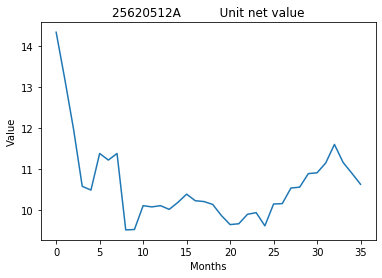

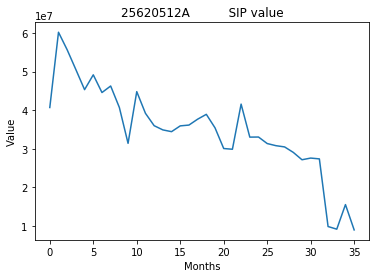

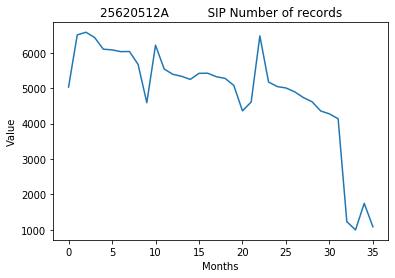

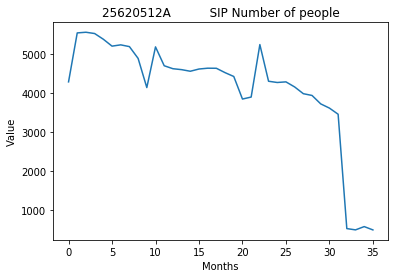

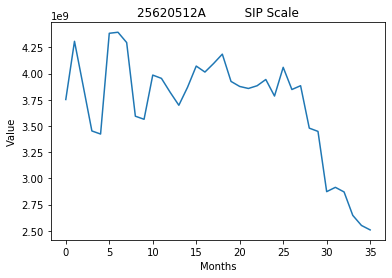

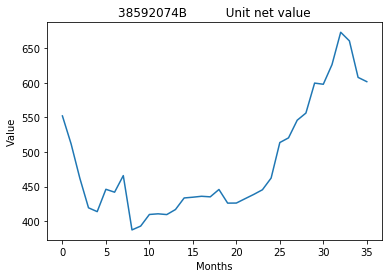

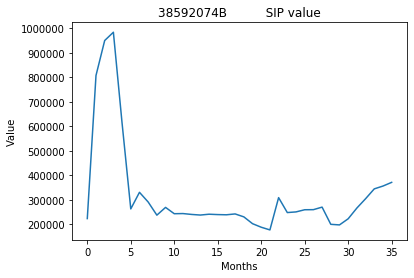

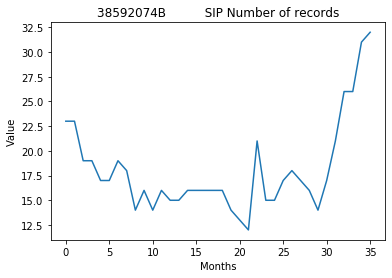

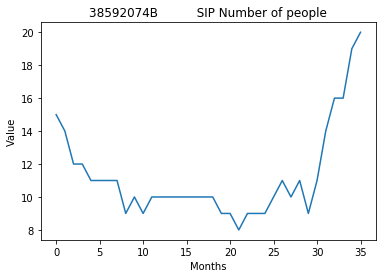

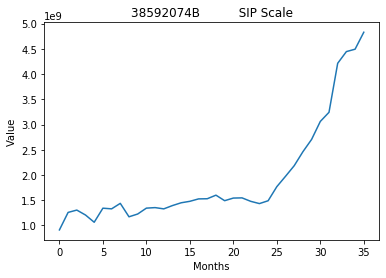

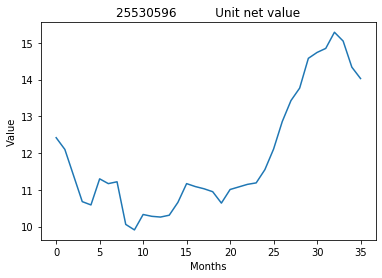

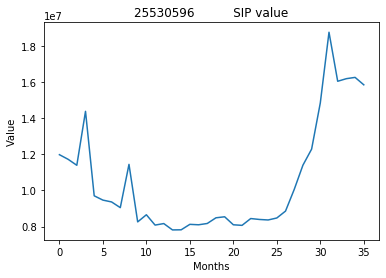

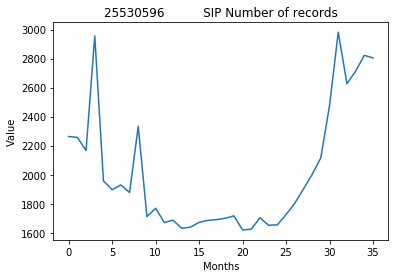

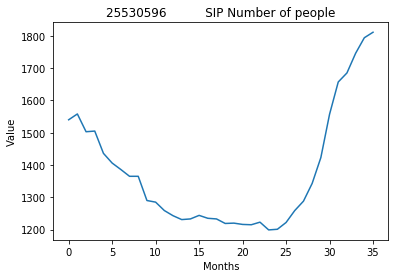

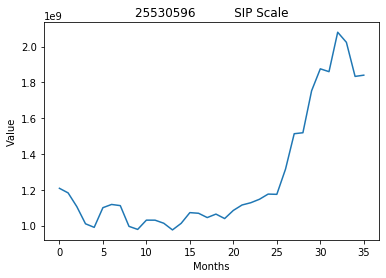

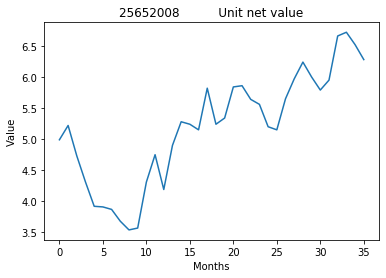

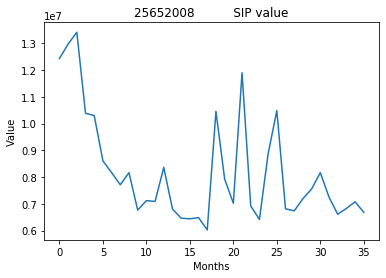

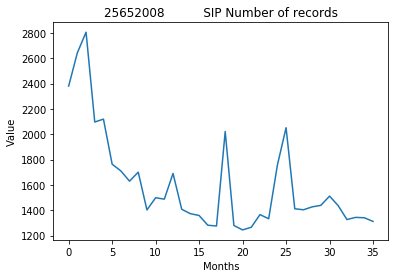

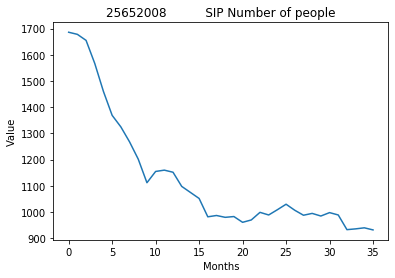

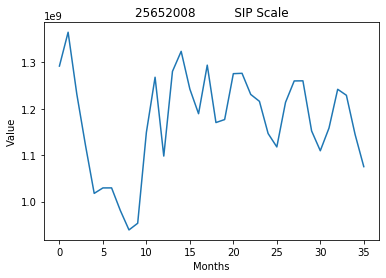

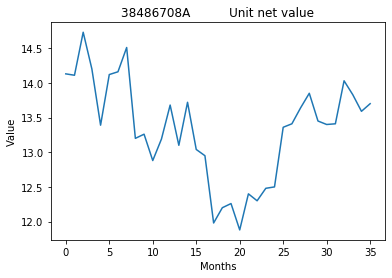

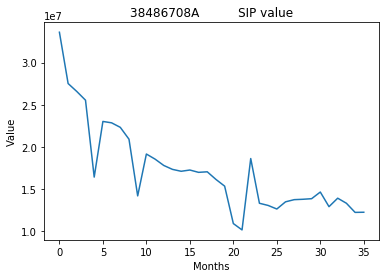

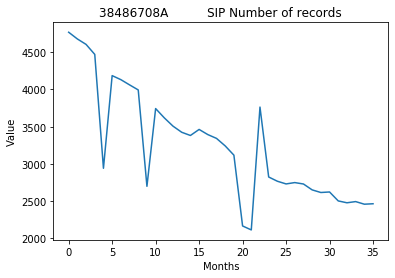

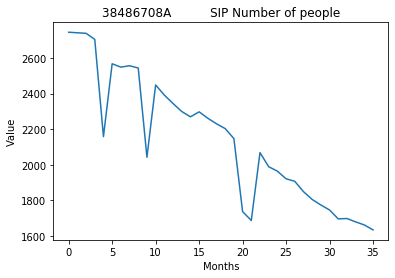

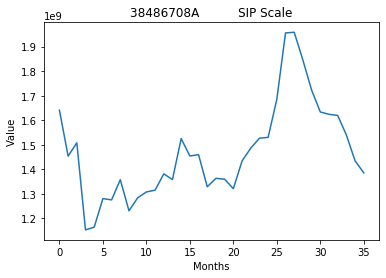

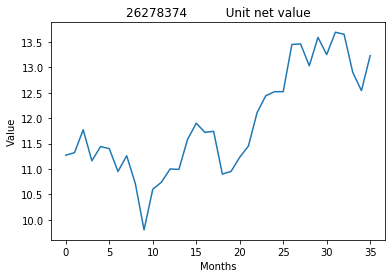

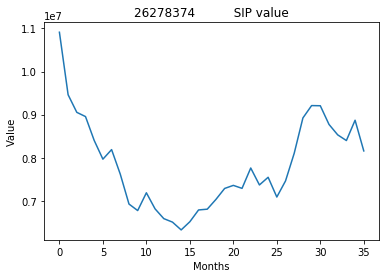

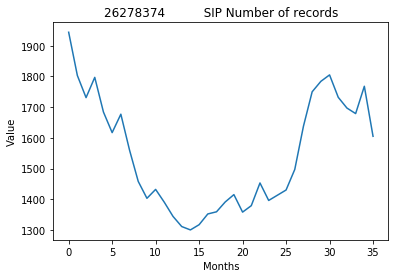

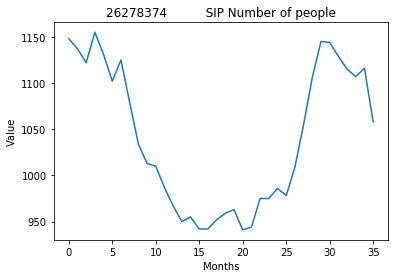

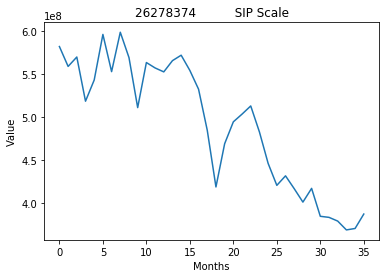

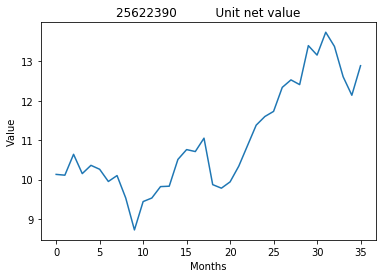

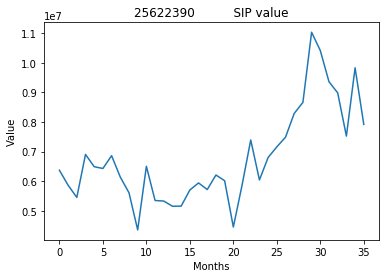

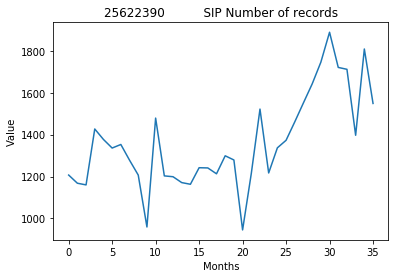

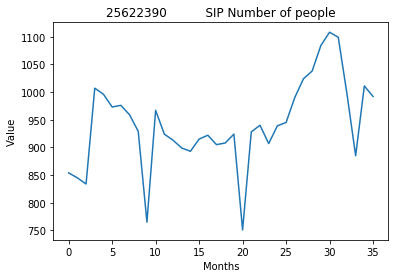

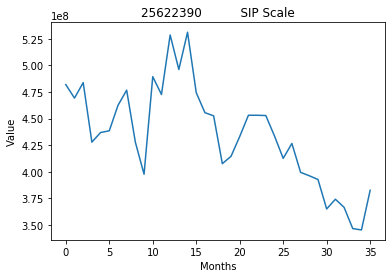

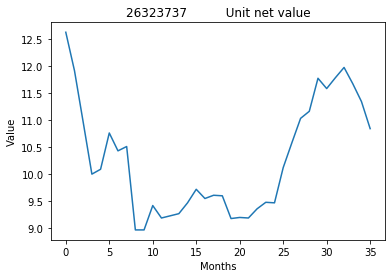

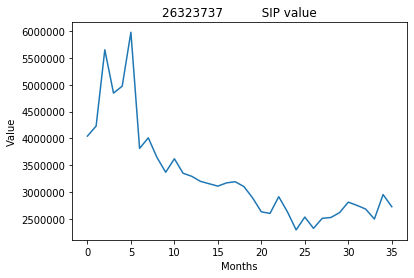

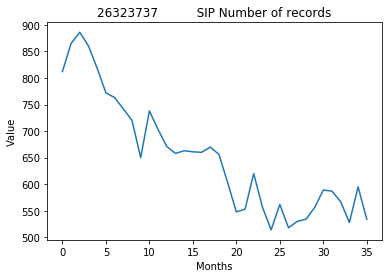

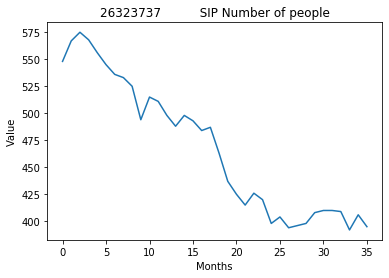

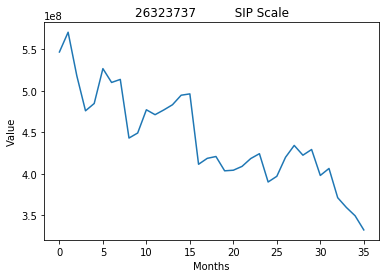

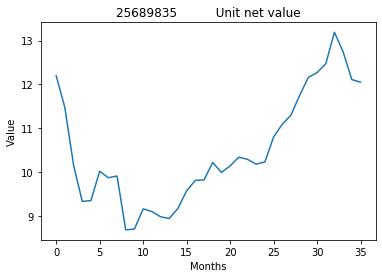

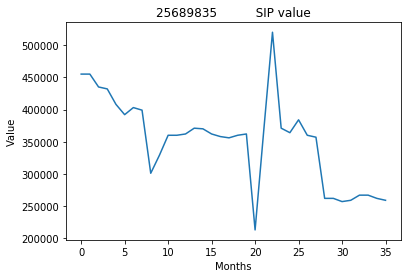

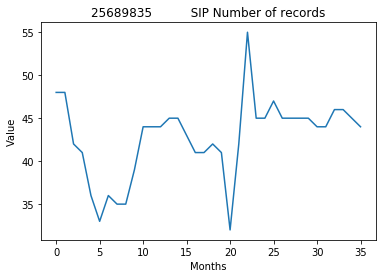

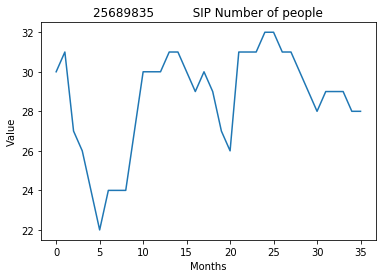

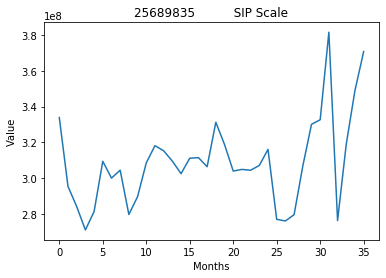

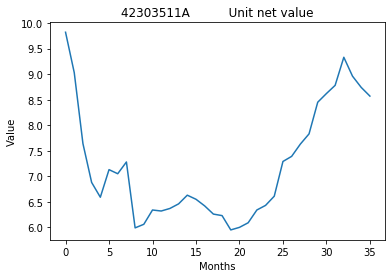

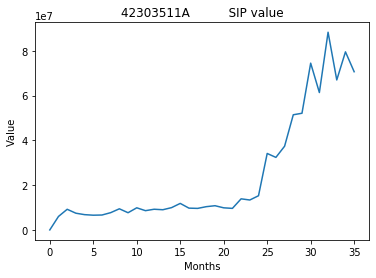

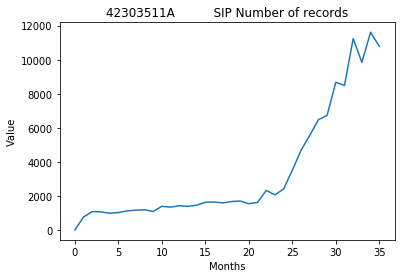

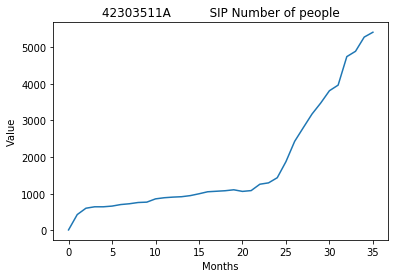

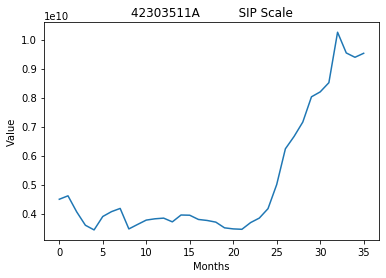

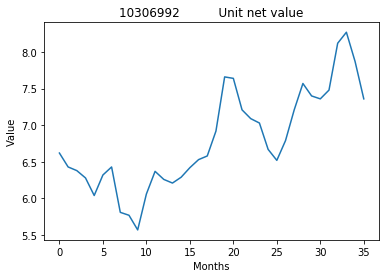

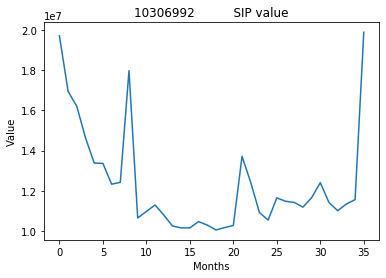

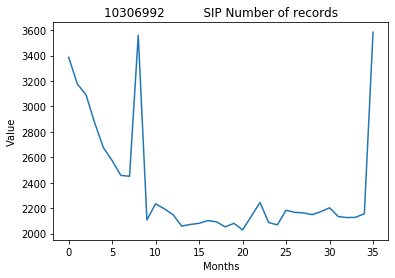

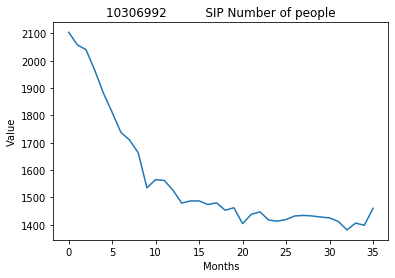

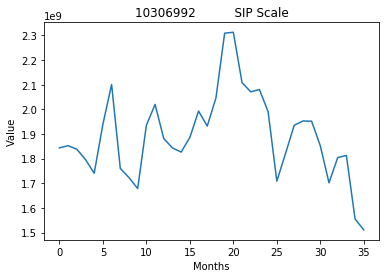

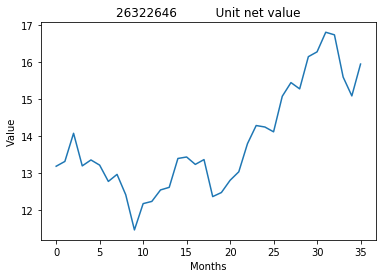

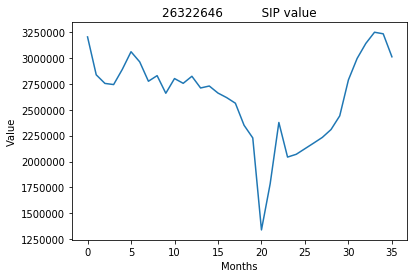

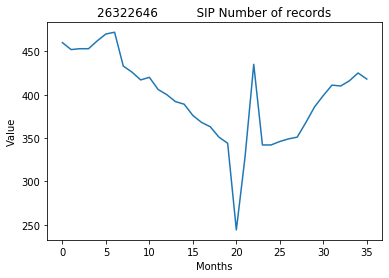

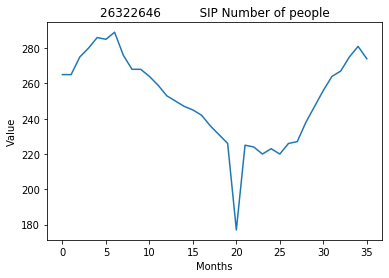

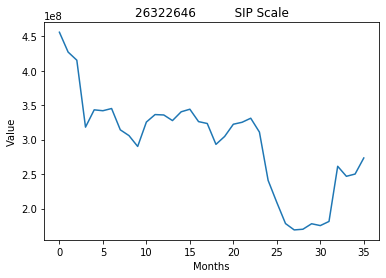

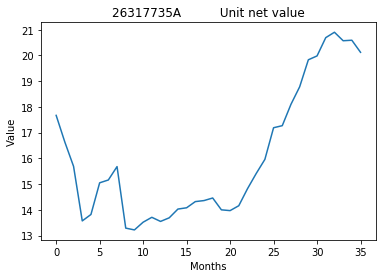

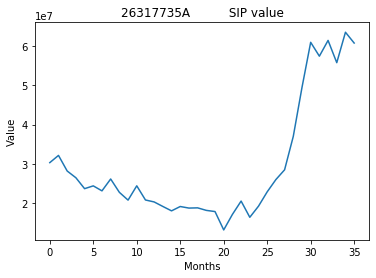

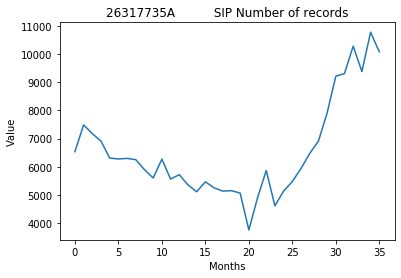

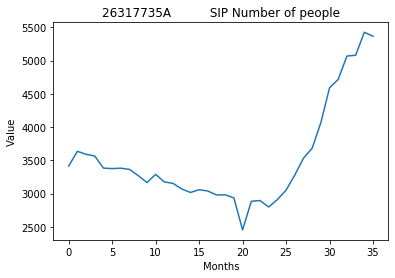

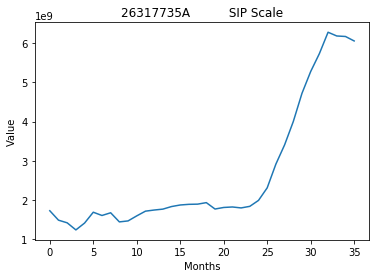

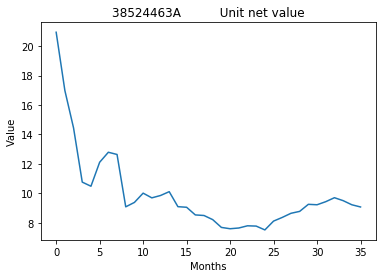

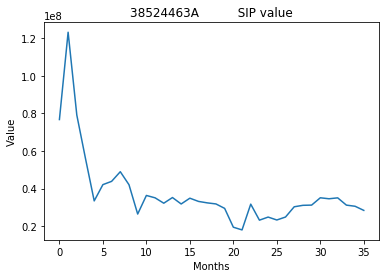

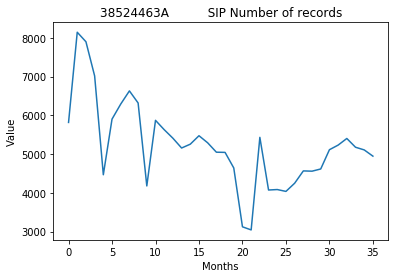

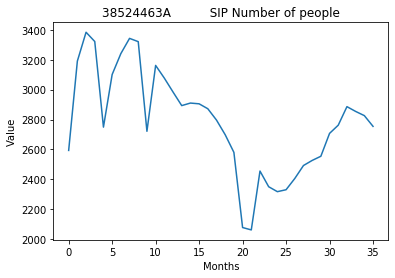

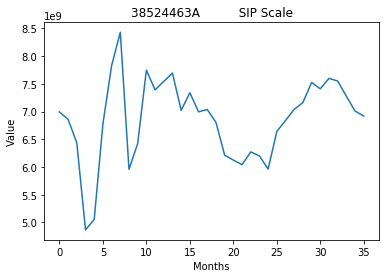

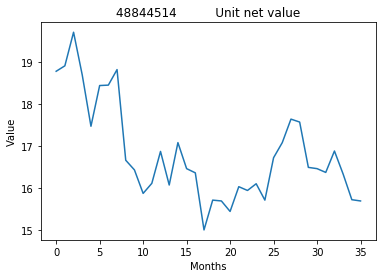

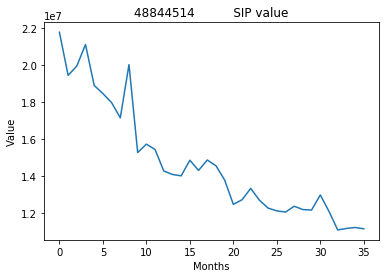

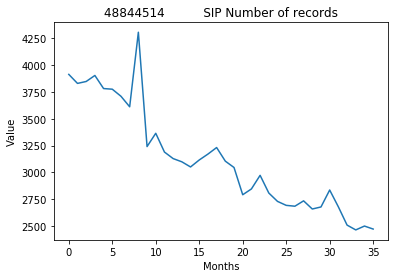

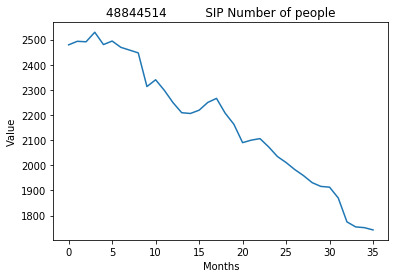

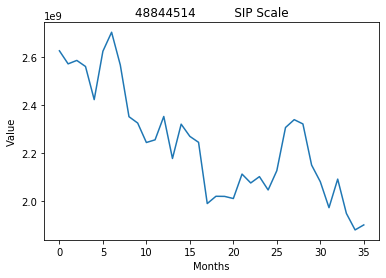

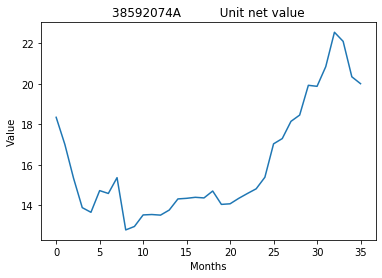

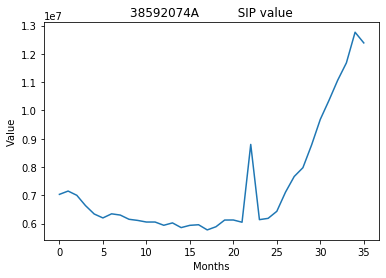

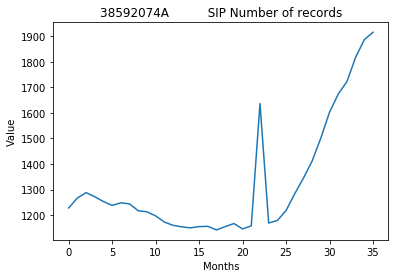

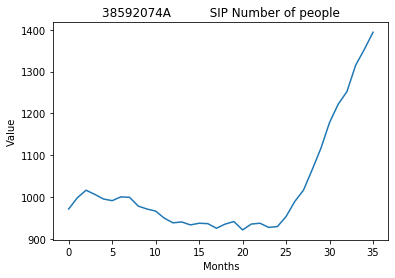

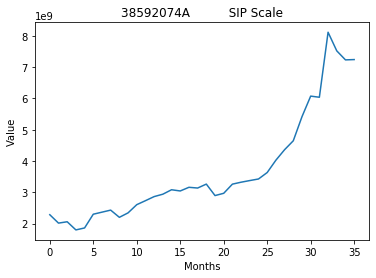

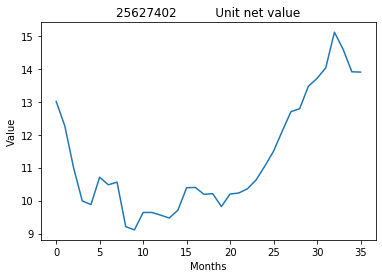

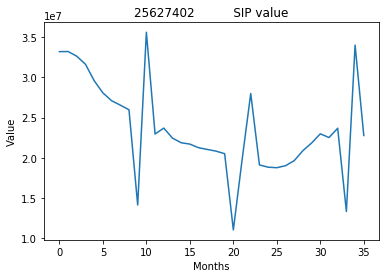

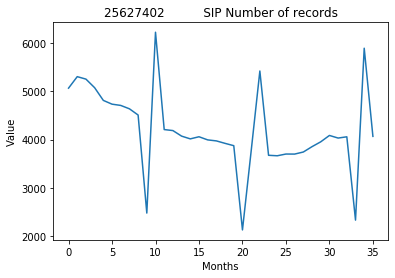

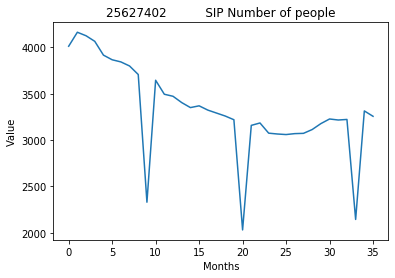

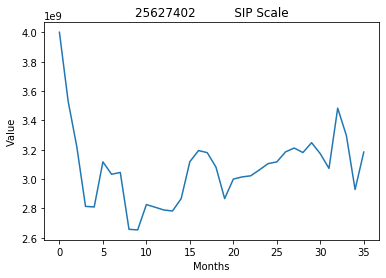

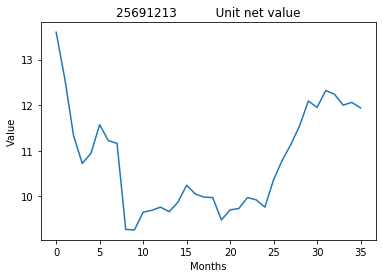

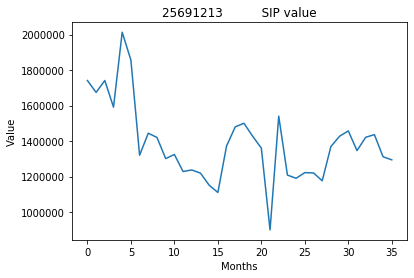

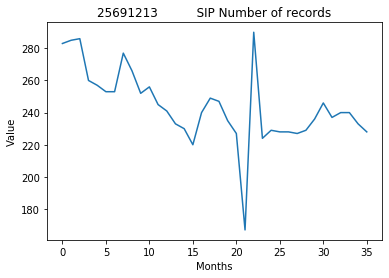

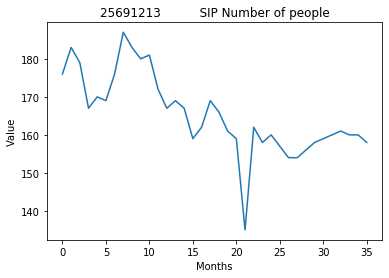

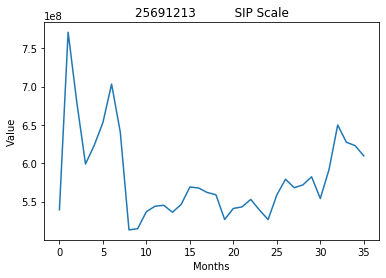

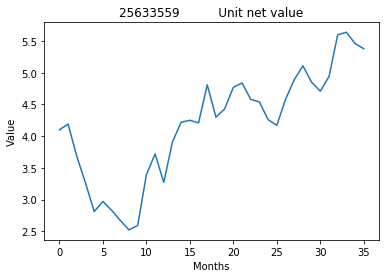

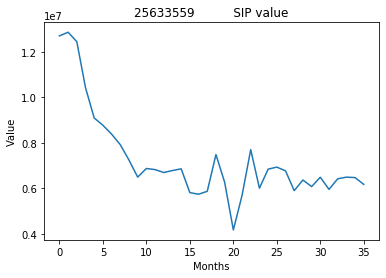

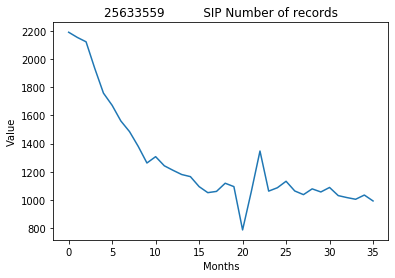

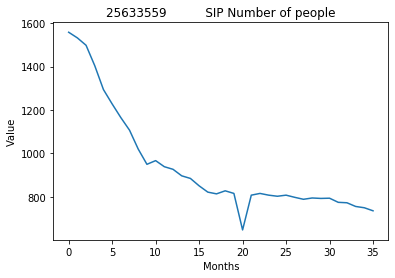

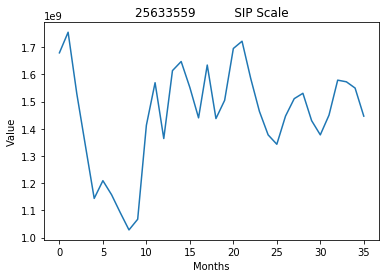

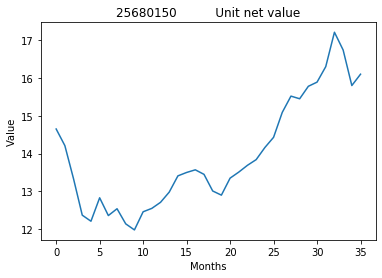

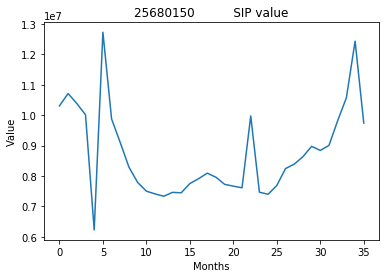

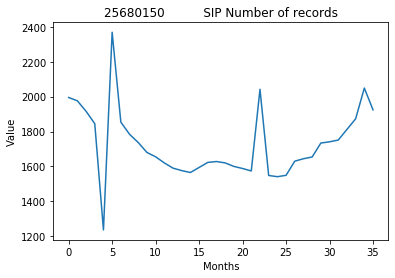

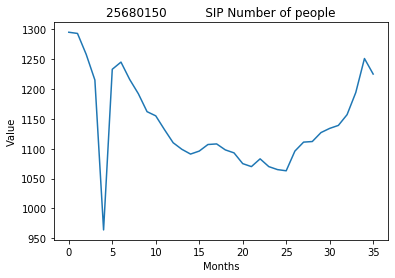

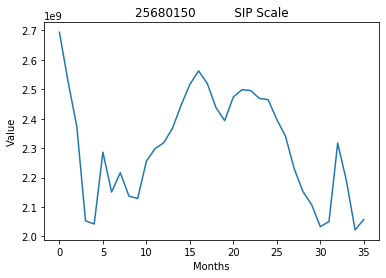

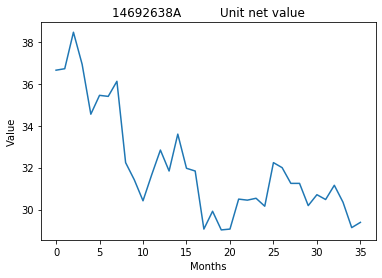

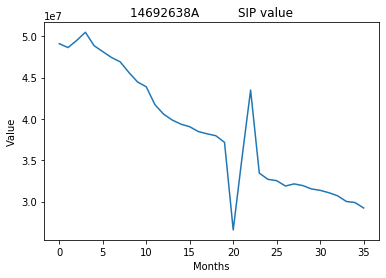

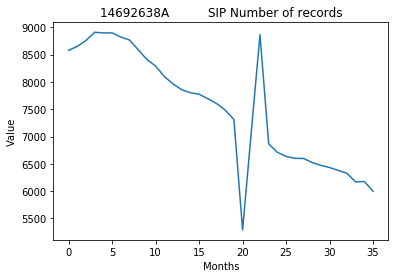

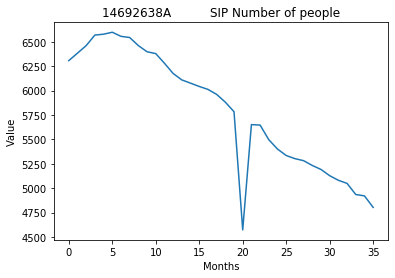

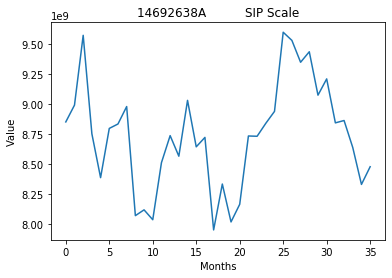

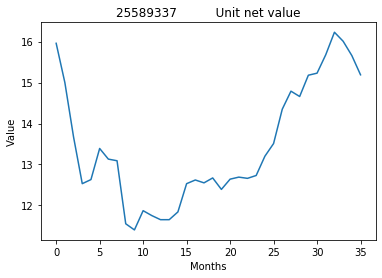

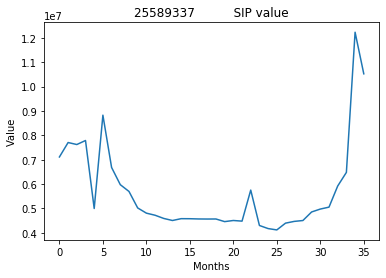

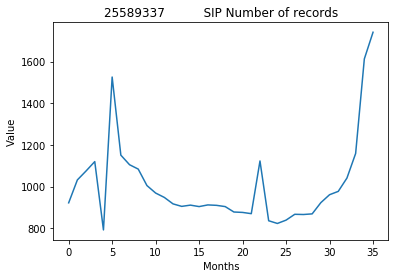

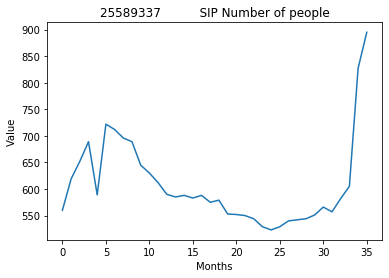

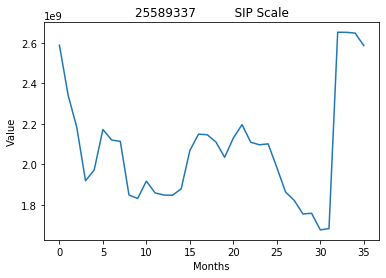

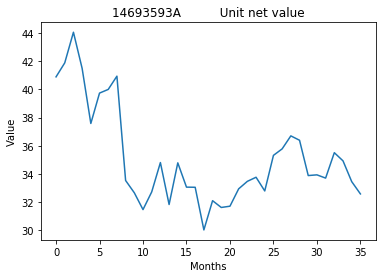

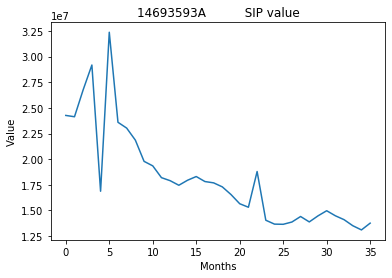

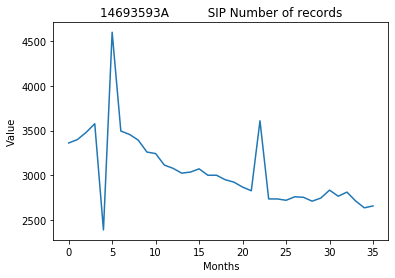

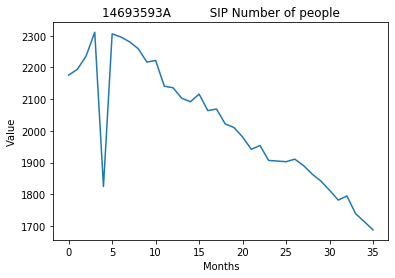

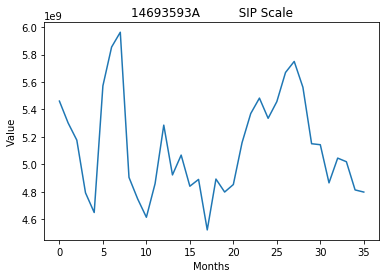

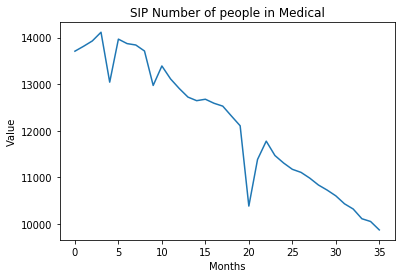

[0, 9, 12, 17, 20, 22, 24, 29, 33]
[0, 5, 6, 9, 12, 16, 17, 20, 25, 27, 29, 30, 31, 35]
[2, 3, 4, 6, 9, 12, 20, 24, 25, 29, 30, 31, 33]
[3, 4, 6, 7, 9, 11, 12, 17, 18, 20, 24, 29, 30, 35]
[0, 5, 6, 7, 9, 12, 19, 20, 24, 32, 35]
['第一金中國世紀基金-新臺幣', '兆豐國際中國A股基金(美金)', '野村中國機會基金', '野村巴西基金', '群益全球關鍵生技基金-新臺幣', '野村雙印傘型基金之印度潛力基金', '元大印度基金', '日盛中國內需動力基金', '德信中國精選成長基金', '復華中國新經濟A股基金-新臺幣', '野村新興傘型基金之大俄羅斯基金', '台新印度基金', '國泰中國內需增長基金台幣級別', '群益中國新機會基金-新臺幣', '野村全球生技醫療基金', '兆豐國際中國A股基金(台幣)', '摩根中國亮點基金', '台新中國精選中小基金', '瀚亞巴西基金', '安聯中國東協基金', '保德信全球醫療生化基金-新臺幣', '安聯中國策略基金', '安聯全球生技趨勢基金-新臺幣']


In [34]:
aliveList = plot_image()
print(aliveList)

In [28]:
newAliveList = []
for name in aliveList:
    if("新臺幣" in name):
        name = name.replace("新臺幣", "台幣")
    if("新台幣" in name):
        name = name.replace("新台幣", "台幣")
    if("台幣類型" in name):
        name = name.replace("台幣類型", "台幣")
    if("N" in name):
        name = name.replace("N", "N類型")
    if("-N類型" in name):
        name = name.replace("-N類型", "")
        name = name.replace("基金", "基金N類型")
    if("級別" in name):
        if("台幣" in name):
            name = name.replace("台幣級別", "(台幣)")
        if("人民幣" in name):
            name = name.replace("人民幣級別", "(人民幣)")
        if("美元" in name):
            name = name.replace("美元級別", "(美元)")
    if("-" in name):
        name = name.replace("-", "(", 1) + ")"
    if("人民幣類型" in name):
        name = name.replace("類型", "")
    if("兆豐國際中國A股基金(美金)" in name):
        name = name.replace("美金", "美元")
    if("安聯中國策略基金" in name):
        name = name + "(台幣)"
    if("台新中國精選中小基金" in name):
        name = name + "(台幣)"
    if("摩根中國A股基金" in name):
        if("摩根中國A股基金(美元)" in name):
            pass
        else:
            name = name + "(台幣)"
    if("瀚亞中國" in name):
        name = name.replace("中國", "中國A股")
    if("野村新興傘型基金之大俄羅斯基金" in name):
        name = name.replace("野村新興傘型基金之大俄羅斯基金", "野村大俄羅斯基金")
    if("野村雙印傘型基金之印度潛力基金" in name):
        name = name.replace("野村雙印傘型基金之印度潛力基金", "野村印度潛力基金")
    newAliveList.append(name)
# newAliveList

In [29]:
pd.set_option('display.max_rows', None)
df2 = pd.read_html("https://www.moneydj.com/funddj/yb/YP302000.djhtm?a=ET003001")
df3 = pd.read_html("https://www.moneydj.com/funddj/yb/yp302000.djhtm?a=ET003002")
df4 = pd.read_html("https://www.moneydj.com/funddj/yb/yp302000.djhtm?a=ET003003")
dfFinal = pd.concat([df2[4], df3[4], df4[4]], axis=0)
dfFinal

日期                                               基金名稱      基金公司  \
        日期                                               基金名稱      基金公司   
0    06/04                          第一金全球AI FinTech金融科技基金(台幣)     第一金投信   
1    06/04                       第一金全球AI FinTech金融科技基金N類型(台幣)     第一金投信   
2    06/04                          第一金全球AI FinTech金融科技基金(美元)     第一金投信   
3    06/04                       第一金全球AI FinTech金融科技基金N類型(美元)     第一金投信   
4    06/04                                           永豐主流品牌基金      永豐投信   
5    06/04                    中國信託全球股票入息基金-分配型(本基金之配息來源可能為本金)    中國信託投信   
6    06/04                    中國信託全球股票入息基金-累積型(本基金之配息來源可能為本金)    中國信託投信   
7    06/04                                       台新智慧生活基金(台幣)      台新投信   
8    06/04                                        元大新中國基金(台幣)      元大投信   
9    06/04                                         安聯全球綠能趨勢基金      安聯投信   
10   06/04                                         野村環球基金(台幣)      野村投信   
11   06/04                                         第一金全球大趨勢基金     第一金投信   
12   06/04                                    華南永昌全球新零售基金(台幣)    華南永昌投信   
13   06/04                                           野村全球品牌基金      野村投信   
14   06/04                                        保德信全球基礎建設基金     保德信投信   
15   06/04                                          日盛全球抗暖化基金      日盛投信   
16   06/04                                           景順全球科技基金      景順投信   
17   06/04                                   中國信託智慧城市建設基金(台幣)    中國信託投信   
18   06/04                                       元大新中國基金(人民幣)      元大投信   
19   06/04                                         華南永昌全球精品基金    華南永昌投信   
20   06/04                                     宏利全球動力股票基金(台幣)      宏利投信   
21   06/04                                     國泰全球基礎建設基金(台幣)      國泰投信   
22   06/04                                       台新智慧生活基金(美元)      台新投信   
23   06/04                                        元大新中國基金(美元)      元大投信   
24   06/04                                         華頓全球時尚精品基金    國票華頓投信   
25   06/04                                         野村環球基金(美元)      野村投信   
26   06/04                                         安聯全球人口趨勢基金      安聯投信   
27   06/04                                  第一金全球AI精準醫療基金(台幣)     第一金投信   
28   06/04                                    華南永昌全球新零售基金(美元)    華南永昌投信   
29   06/04                               第一金全球AI精準醫療基金N類型(台幣)     第一金投信   
30   06/04                                        野村環球基金(人民幣)      野村投信   
31   06/04                                         瑞銀全球創新趨勢基金      瑞銀投信   
32   06/04                    群益工業國入息基金B月配型(台幣)(本基金配息來源可能為本金)      群益投信   
33   06/04                    群益工業國入息基金A累積型(台幣)(本基金配息來源可能為本金)      群益投信   
34   06/04                   群益工業國入息基金NA累積型(台幣)(本基金配息來源可能為本金)      群益投信   
35   06/04                                      富邦大中華成長基金(台幣)      富邦投信   
36   06/04                                       凱基雲端趨勢基金(台幣)      凱基投信   
37   06/04                          第一金全球AI機器人及自動化產業基金N類型(台幣)     第一金投信   
38   06/04                             第一金全球AI機器人及自動化產業基金(台幣)     第一金投信   
39   06/04                                   中國信託智慧城市建設基金(美元)    中國信託投信   
40   06/04                                         元大全球農業商機基金      元大投信   
41   06/04                                             摩根龍揚基金      摩根投信   
42   06/04                                        保德信全球消費商機基金     保德信投信   
43   06/04                                     國泰全球基礎建設基金(美元)      國泰投信   
44   06/04                                 摩根環球股票收益基金-累積型(台幣)      摩根投信   
45   06/04                  摩根環球股票收益基金-月配型(台幣)(本基金之配息來源可能為本金)      摩根投信   
46   06/04                                      保德信全球中小基金(台幣)     保德信投信   
47   06/04                                      統一全球新科技基金(台幣)      統一投信   
48   06/04                  群益工業國入息基金NB月配型(人民幣)(本基金配息來源可能為本金)      群益投信   
49   06/04                   群益工業國入息基金B月配型(人民幣)(本基金配息來源可能為本金)      群益投信   
50   06/04                   群益工業國入息基金A累積型(人民幣)(本基金配息來源可能為本金)      群益投信   
51   06/04                  群益工業國

In [30]:
for name in newAliveList:
    filterName = (dfFinal["基金名稱"]["基金名稱"] == name)
    try:
        print(dfFinal[filterName]["報酬率(%)"]["六個月"].values[0])
    except:
        print(name)

2.93
5.42
6.33
12.13
-0.45
11.84
11.51
1.91
7.75
12.89
14.86
8.53
1.59
2.5
-1.43
6.56
1.08
-0.11
11.63
0.66
-2.01
15.24
-3.02
